In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

Load system model from Excel

In [2]:
model = pd.read_excel('Example11_9_Network_Model_zeromc_flexload.xlsx', sheet_name=None)

Problem parameters, modeled after the network in Example 11_9 in PowerWorld Simulator 18 (Glover, Sarma & Overbye Edition) [Fourth Edition Sample Cases](https://www.powerworld.com/simulator-18-glover-sarma-overbye-edition-download)

In [3]:
# Read Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# System base, in MVA
base = 100

# Fixed consumption and price
p_d_0 = np.array(model['Load']['MW'])/base
price = np.array(model['Load']['Price'])

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Minimum and maximum generator outputs, taken from PowerWorld
p_g_max = np.array(model['Gen']['Max MW'])/base

# The buses with generators and loads
L = ~model['Bus']['Load MW'].isna()
L = np.array(L.index[L])
G = ~model['Bus']['Gen MW'].isna()
G = np.array(G.index[G])

# Transformation matrices. These define the change-of-variables from the generator/load spaces to the bus space.
AG = np.zeros((N,len(G)))
AG[G,:] = np.eye(len(G))
AL = np.zeros((N,len(L)))
AL[L,:] = np.eye(len(L))

We solve a **demand-side** problem with zero marginal cost, fixed supply, and elastic demand. For this minimal example, we make the follwing assumptions:
- Each load submits a demand curve. The system operator dispatches to maximize total utlity $U(P)$.
- For each load, elasticity is constant. That is, the marginal utility for load $i$ is given by $\frac{dU_i}{dP_i}=K_iP_i^{\frac{1}{e_i}}$, where $e_i<0$ is the elasticity. Note that this formulation insures that marginal benefit is always positive.
- There is no upper limit on consumption.

This function accepts:
- An elasticity $e$ (constant across loads for now)
- A nominal operating point for load $(\hat{P}_d,\lambda)$ such that $\nabla_{P_d}U(\hat{P}_d)=\mathbf{1}\lambda$
- A vector of nominal generator outputs $P_g$
- A scaling factor for generator outputs

It returns a pandas series fully specifying the simulation.

In [4]:
def sim(e, price, p_d_0, p_g_max, factor):

    K = price/(p_d_0)**(1/e)

    p_d = cp.Variable(len(L))
    p_g = cp.Variable(len(G))
    delta = cp.Variable(N)
    constraints = [
        AG@p_g-AL@p_d == -B@delta,
        cp.multiply(B, delta[:,np.newaxis]-delta[np.newaxis,:]) <= P_line,
        p_g <= factor*p_g_max
    ]
    U = cp.Problem(
        cp.Maximize(e/(1+e)*cp.sum(cp.multiply(K,(p_d)**(1/e+1)))),
        constraints
    ).solve()

    return pd.Series(
        {
            'e': e,
            'price': price,
            'p_0': p_d_0,
            'p_g': p_g.value,
            'factor': factor,
            'p_d': p_d.value,
            'LMP': -constraints[0].dual_value,
            'congestion': constraints[1].dual_value,
            'U': U
        }
    )

Let's do a sweep across generator factors for a couple different elasticities. We'll choose $\hat{P}_d$, $\lambda$, and $P_g$ using the parameters and solution to the supply-side problem.

In [5]:
elasticities = [-0.7, -0.3]
factors = np.linspace(0.3, 1.5)
results = pd.DataFrame(
    [
        sim(e, price, p_d_0, p_g_max, factor) 
        for e in elasticities
        for factor in factors
    ]
)

/opt/conda/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: 

Plot the results. Each color is a different elasticity, with one line per bus representing that bus' LMP.

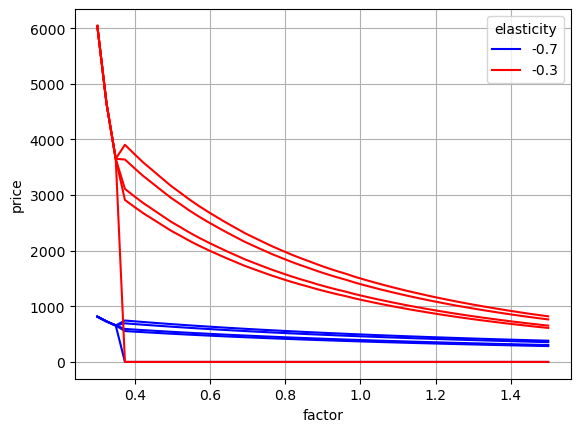

In [6]:
fig, ax = plt.subplots()
colors = dict(zip(elasticities, ['blue', 'red']))
results.set_index('factor').groupby('e').apply(lambda df: df.LMP.apply(pd.Series).plot(ax=ax, color=colors[df.name]))
ax.grid()
ax.set_ylabel('price')
[line.set_label(elasticities[i//5] if line.get_label() == '0' else '_nolegend_') for i, line in enumerate(ax.lines)]
ax.legend(title='elasticity')
fig.show()